## Anomaly Detection in MVTec Dataset

Different experiments will be done in this workspace.

Used Models:
* `ConvAE Model`
* `CBAM ConvAE Model`
* `Residual CBAM ConvAE Model`

Batch size: `16`

Epochs: Changes between `100~500` epochs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/backbones.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [ ]:
from utils import vision
from utils import utils
from utils import losses
from utils import models
from utils import backbones
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

### Experiment Setup Start

In [ ]:
# Create experiment folder
EXPERIMENT_NAME = 'CBAM_ConvAE_Model_MVTec'
EXPERIMENT_SAVE_DIR = os.path.join('/content/drive/MyDrive/MASTER/Master_Thesis/Experiments', EXPERIMENT_NAME)
EXPERIMENT_PRELOAD_WEIGHTS_FROM = 'experiment_2'  # ex. 'experiment_2'

In [ ]:
experiment = {
    'TYPE': 'test',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    # Input data
    'DATASET': 'MVTec_transistor_Dataset',
    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'PATCH_SIZE': 256,
    'MAX_GRID_NUM': 4,      # Number of maximum grids to be used in partitioning the input image
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': False,      # Apply data augmentation
    'DATA_AUG_POWER': 2,    # Data augmentation power: How many times data
     # augmentation will be applied to the whole dataset. default 1
    'MAX_TEST_IMAGES': 50,  # default: -1, Get all images from the testing dataset

    # Model
    'BACKBONE': 'ResCBAM_ConvAE',   # 'ConvAE', 'CBAM_ConvAE' or 'ResCBAM_ConvAE'
    'DECODER_ATTENTION': True,      # If True, CBAM attention layer in both encoder and decoder layer
    'REDUCTION_RATIO': 16,          # CBAM layer reduction ratio
    'FIRST_TRANIABLE_LAYER_IX': None,  # First trainable layer of pre-trained backbone models - "block4_pool"
    'BATCH_SIZE': 16,               # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 200,
    'OPTIMIZER': tf.keras.optimizers.Adam,
    'LEARNING_RATE': 1e-4,
    'LATENT_DIM': 512,  # set latent dim - shape: (LATENT_DIM, 1) - default 200

    # Loss
    'RECONS_LOSS': tf.keras.losses.mean_squared_error,  # Reconstruction loss (use tf intrinsic methods: tf.keras.losses.mean_absolute_error or losses.ssim_loss)
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    # Perceptual Loss
    'PERCEPTUAL_LOSS': False, # Use Perceptual loss
    'PERCEPTUAL_LOSS_MODEL': 'ResNet50', # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'VGG16'
    'PERCEPTUAL_LAYERS': [35,77,139,150],    # 'conv2_block3_3_conv', 'conv3_block4_3_conv', 'conv4_block6_3_conv', 'conv5_block1_3_conv'
    'PERP_LOSS_LAMBDA': 1,      # Perceptual loss coeff
    'MSE_LOSS_LAMBDA': 0.5,     # MSE coeff

    # Save model
    'PRE_LOAD_WEIGHTS': None, # Start to train model with initial weights come from previous training process - Set epoch number (50, 100, etc.)
    'SAVE_WEIGHTS_PER_EPOCH': 25,  # Checkpoints
}

In [ ]:
if experiment['TYPE'] == 'train':
    assert(EXPERIMENT_NAME != '...')
    # Create experiment folder
    os.makedirs(EXPERIMENT_SAVE_DIR, exist_ok=True)

    # Model checkpoints will be save in exp_save_dir
    exp_save_dir = utils.create_experimental_output(experiment, EXPERIMENT_SAVE_DIR)

    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
    # Create folder for checkpoints (training weights)
    os.makedirs(TRAINING_WEIGHT_DIR, exist_ok=True)

    if experiment['PRE_LOAD_WEIGHTS'] != None:
        assert(EXPERIMENT_PRELOAD_WEIGHTS_FROM != None)
        # Start to train model with initial weights come from previous training process
        exp_save_dir = os.path.join(EXPERIMENT_SAVE_DIR, EXPERIMENT_PRELOAD_WEIGHTS_FROM)
        PRE_LOAD_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')
else:  # test mode
    assert(EXPERIMENT_PRELOAD_WEIGHTS_FROM != None)
    # Set experiment save directory and training weight directory manually
    exp_save_dir = exp_save_dir = os.path.join(EXPERIMENT_SAVE_DIR, EXPERIMENT_PRELOAD_WEIGHTS_FROM)
    TRAINING_WEIGHT_DIR = os.path.join(exp_save_dir, 'training_weights')

In [ ]:
print(f"...Experiment {exp_save_dir.split('experiment_')[1]} was initialized...")
print(f"Experiment directory: {EXPERIMENT_SAVE_DIR}")
print(f"Training weights save directory: {TRAINING_WEIGHT_DIR}")

...Experiment 2 was initialized...
Experiment directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model_MVTec
Training weights save directory: /content/drive/MyDrive/MASTER/Master_Thesis/Experiments/CBAM_ConvAE_Model_MVTec/experiment_2/training_weights


### Experiment Setup End

### Dataset Pre-processing Start

In [ ]:
# MVTec Transistor dataset from Kaggle
# https://www.kaggle.com/datasets/leezhixiong/mvtec-transistor-dataset

! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ipythonx/mvtec-ad

utils.unzip_data("/content/mvtec-ad.zip")
! rm /content/mvtec-ad.zip

100% 4.90G/4.91G [00:56<00:00, 115MB/s] 
100% 4.91G/4.91G [00:56<00:00, 93.4MB/s]


Set MVTec Dataset Paths for sub datasets

In [ ]:
ROOT_PATH = "/content"

# Parse experiment dataset config, get sub dataset folder name
subfolder_name = ((experiment['DATASET'].split("MVTec_")[-1]).split("_Dataset")[0])
TRAIN_DATASET_GOOD_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/train/good"))
TRAIN_DATASET_DEFECT_PATH = None

TEST_DATASET_GOOD_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/test/good"))
TEST_DATASET_DEFECT_PATH = os.path.join(ROOT_PATH, (subfolder_name + "/test"))

In [ ]:
print("TRAIN DATASET GOOD")
# Do not need to separate training dataset into train_good and train_defect (unsupervised learning)
train_dataset_files = utils.get_all_img_files_in_directory(TRAIN_DATASET_GOOD_PATH, ext="png", verbose=1)

#print("TEST DATASET GOOD")
#test_dataset_good_files = utils.get_all_img_files_in_directory(TEST_DATASET_GOOD_PATH, ext="png", verbose=1)

print("TEST DATASET DEFECTED")
# Exclude Test Dataset Good Files, get all others
test_dataset_defect_files = utils.get_all_img_files_in_directory(TEST_DATASET_DEFECT_PATH, ext="png", exc="good", verbose=1)

TRAIN DATASET GOOD
There are 0 directories and 213 files in '/content/transistor/train/good'.
TEST DATASET DEFECTED
There are 5 directories and 0 files in '/content/transistor/test'.
There are 0 directories and 10 files in '/content/transistor/test/cut_lead'.
There are 0 directories and 10 files in '/content/transistor/test/misplaced'.
There are 0 directories and 10 files in '/content/transistor/test/bent_lead'.
There are 0 directories and 10 files in '/content/transistor/test/damaged_case'.
Files in the '/content/transistor/test/good' path was not included in the file list
There are 0 directories and 60 files in '/content/transistor/test/good'.


In [ ]:
LABELS = ["Defect-free", "Defected"]

Training dataset Validation Split

In [ ]:
# Training/Validation Split
train_valid_separator = len(train_dataset_files) - int(len(train_dataset_files) * experiment['VALID_SIZE'])

print(f"Number of defect free {subfolder_name} images in the training dataset: {len(train_dataset_files[:train_valid_separator])}")
print(f"Number of defect free {subfolder_name} images in the validation dataset: {len(train_dataset_files[train_valid_separator:])}")
print(f"Number of defect free {subfolder_name} images: {len(train_dataset_files[:train_valid_separator])+len(train_dataset_files[train_valid_separator:])}")
print(f"Number of defected {subfolder_name} images in the testing dataset: {len(test_dataset_defect_files)}")
#print(f"Number of defect free {subfolder_name} images in the testing dataset: {len(test_dataset_good)}")

Number of defect free transistor images in the training dataset: 192
Number of defect free transistor images in the validation dataset: 21
Number of defect free transistor images: 213
Number of defected transistor images in the testing dataset: 40


### get_new_image_size_according_to_patch_size() method usage

We use a patch-wise anomaly searching technique. BATCH_SIZE = (256, 256). We will find the best-fitting width and height values for the dataset.

Ex:

test_img.shape[0] # Heigth: 2816px

test_img.shape[1] # Width: 4096px

test_img.shape[0] // `experiment['PATCH_SIZE']` # Heigth: 11 row

test_img.shape[1] // `experiment['PATCH_SIZE']` # Width: 16 column

16*11 = 176 grid (too much to handle). We accept `maximum 36 grids`.

Number of maximum Grids: 36 - Optimal Input Shape: (256, 256, 3)

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=36,
                                                verbose=1)
```

Output:
>> Modified Image size: (1024, 1024)

No change in the input image size. A total of `16` grid was accepted.

IF we enter fewer max number of grids value like:

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=2,
                                                verbose=1)
```

Output:
>> Modified Image size: (256, 256)

A total of `1` grid was accepted.

```python
utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                experiment['PATCH_SIZE'],
                                                max_grid_num=4,
                                                verbose=1)
```

Output:
>> Modified Image size: (512, 512)

A total of `4` grid was accepted.

Test image shape: (1024, 1024, 3)


(-0.5, 1023.5, 1023.5, -0.5)

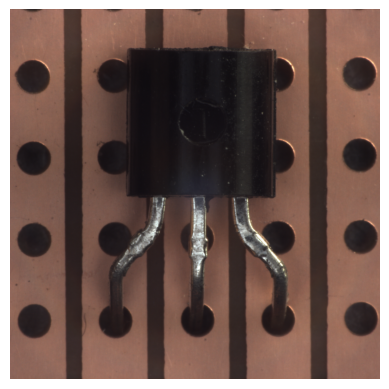

In [ ]:
test_img = utils.load_images(train_dataset_files[1], scl=True)
print(f"Test image shape: {test_img.shape}")

plt.imshow(test_img)
plt.axis('off')

Get Modified Image size and number of Width/Height grids

In [ ]:
modified_image_size, grid_width, grid_height = utils.get_new_image_size_according_to_patch_size(test_img.shape[:2],
                                                                                                experiment['PATCH_SIZE'],
                                                                                                max_grid_num=experiment['MAX_GRID_NUM'],
                                                                                                verbose=1)

Original Image size: (1024, 1024)
Original image aspect ratio: 1.0
Width grid: 2, Heigth grid: 2
Defect Detail Power/Coeff: 4 (Maximum: 36 (grids))
Modified aspect ratio: 1.0
Modified Image size: (512, 512)


Data Augmentation Layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

if experiment['DATA_AUG']:
    # Setup data augmentation
    data_aug_layer = Sequential([
      #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
      #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
      #preprocessing.RandomZoom(0.2), # randomly zoom into an image
      tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
      # value_range parameter should be [0.0, 1.0] for RandomBrightness
      # if images were scaled before, default value is [0,255]
      tf.keras.layers.RandomContrast(0.2, seed=None),
      #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
      #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
      #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
      #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
    ], name="data_aug_layer")
else:
    data_aug_layer = None

In [ ]:
import random

random.seed(24)

random.shuffle(train_dataset_files)
train_dataset_files = train_dataset_files[:train_valid_separator]

In [ ]:
print(f"Number of {subfolder_name} images in the training dataset: {len(train_dataset_files)}")

Number of transistor images in the training dataset: 192


Create TF Dataset Pipeline

In [ ]:
train_dataset = utils.create_dataset_pipeline(train_dataset_files, batch_size=experiment['BATCH_SIZE'],
                                              img_size=modified_image_size, scl=True, patch_size=experiment['PATCH_SIZE'],
                                              aug_layer=data_aug_layer, data_aug_power=experiment['DATA_AUG_POWER'],
                                              accelerator='GPU')

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  144


### Dataset Pre-processing End

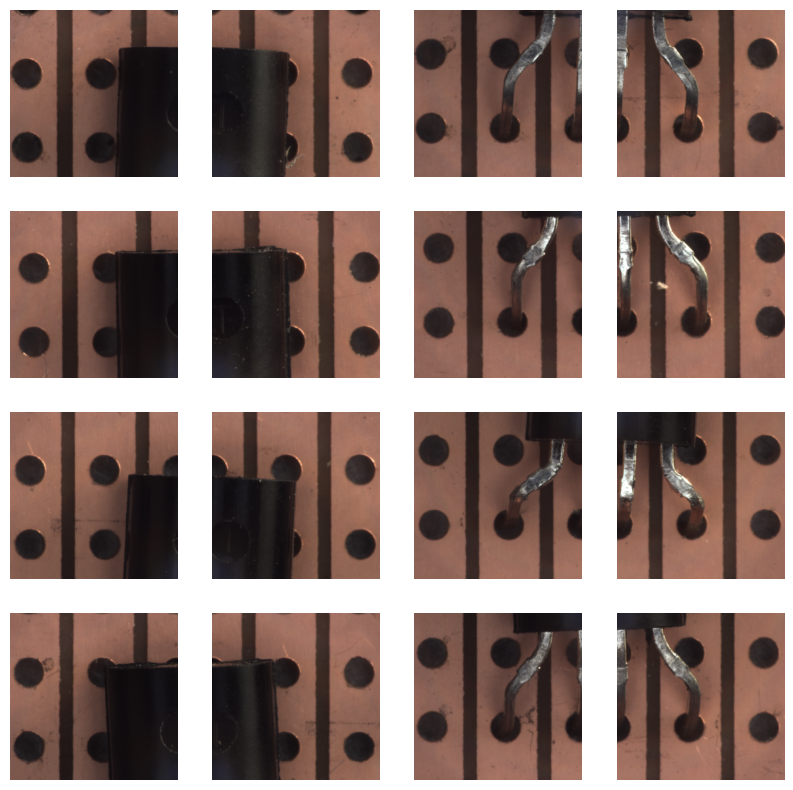

In [ ]:
vision.show_image_samples_from_batch(train_dataset)

### Model Training Start

Create Custom Anomaly Detection Model

In [ ]:
if experiment['BACKBONE'] == 'ConvAE':
    # ConvAE Model
    custom_model = utils.build_ConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                             latent_dim=experiment['LATENT_DIM'],
                                             lrelu_alpha=experiment['LRELU_SLOPE'])
elif experiment['BACKBONE'] == 'CBAM_ConvAE':
    # CBAM ConvAE Model
    custom_model = utils.build_CBAMConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                                 latent_dim=experiment['LATENT_DIM'],
                                                 reduction_ratio=experiment['REDUCTION_RATIO'],
                                                 attention_for_decoder=experiment['DECODER_ATTENTION'],
                                                 lrelu_alpha=experiment['LRELU_SLOPE'])
elif experiment['BACKBONE'] == 'ResCBAM_ConvAE':
    # Residual CBAM ConvAE Model
    custom_model = utils.build_ResCBAMConvAEModelV1(input_shape=experiment['INPUT_SHAPE'],
                                                    latent_dim=experiment['LATENT_DIM'],
                                                    reduction_ratio=experiment['REDUCTION_RATIO'],
                                                    attention_for_decoder=experiment['DECODER_ATTENTION'],
                                                    lrelu_alpha=experiment['LRELU_SLOPE'])

custom_model.summary()

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print("test_input.shape: ", test_input.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')
    if i >= 15:
      break

  #plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

In [ ]:
if experiment['ACCELERATOR'] != 'TPU':
  @tf.function
  def train_step(images):
      with tf.GradientTape() as tape:
          generated_images = custom_model(images, training=True)
          #loss = custom_model.compute_mse_perceptual(images, generated_images)
          loss = custom_model.loss(images, generated_images)

      gradients = tape.gradient(loss, custom_model.trainable_variables)
      custom_model.optimizer.apply_gradients(zip(gradients, custom_model.trainable_variables))

      return loss

In [ ]:
from IPython import display
import time

if experiment['ACCELERATOR'] != 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      for epoch in range(epochs):
          start = time.time()
          for image_batch in dataset:
              loss = train_step(image_batch)

          loss_hist.append(loss)   # Add loss value to the loss history after each epoch
          print("loss: ", tf.reduce_mean(loss).numpy())

          # Set real epoch value for progressive training process
          real_epoch = epoch
          if experiment['PRE_LOAD_WEIGHTS'] != None:
              real_epoch += experiment['PRE_LOAD_WEIGHTS']

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (real_epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            seed = image_batch[:experiment['BATCH_SIZE']]
            display.clear_output(wait=True)
            generate_and_save_images(custom_model,
                                      real_epoch + 1,
                                      seed)

            # Save checkpoints
            utils.save_experiment_checkpoints([custom_model], epoch=(real_epoch+1), save_dir=TRAINING_WEIGHT_DIR)

            print ('Time for epoch {} is {} sec'.format(real_epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images(custom_model,
                              real_epoch+1,
                              seed)

      return loss_hist

In [ ]:
if experiment['TYPE'] == 'train':
    custom_model.compile(loss=experiment['RECONS_LOSS'],
                         optimizer=experiment['OPTIMIZER'](learning_rate=experiment['LEARNING_RATE']))

    # Start training the model with previously trained weights
    if experiment['PRE_LOAD_WEIGHTS'] != None:
        # Start to train model with initial weights come from previous training process
        utils.load_model_experiment_weights([custom_model], epoch=experiment['PRE_LOAD_WEIGHTS'], load_dir=PRE_LOAD_WEIGHT_DIR)

    custom_model_hist = train(train_dataset, experiment['EPOCHS'])
else:  # test/inference mode
    # Set load weight epoch number manually
    utils.load_model_experiment_weights([custom_model], epoch=experiment['EPOCHS'], load_dir=TRAINING_WEIGHT_DIR)

In [ ]:
if experiment['TYPE'] == 'train':
    utils.remove_training_weights_except_last_epoch(TRAINING_WEIGHT_DIR)  # Remove weights except last epoch's

### Model Training End

### Experiment Analysis and Evaluation Start

Model Training Loss Histroy

In [ ]:
if experiment['TYPE'] == 'train':
    plt.plot(custom_model_hist)

In [ ]:
def get_generated_image_batch(data):
    reconstructed_batch = None

    for image_batch in data:
      generated_batch = custom_model.predict(image_batch)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))

      if reconstructed_batch.shape[0] > 5000:
          break

    return reconstructed_batch

Get Generated Data using Training dataset

In [ ]:
generated_train_data = get_generated_image_batch(train_dataset.take(1))  # Use only first batch
generated_train_data.shape

In [ ]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

In [ ]:
show_generated_images(generated_train_data)

In [ ]:
test_dataset_defect_files = test_dataset_defect_files[:experiment['MAX_TEST_IMAGES']]

Create TF Dataset Pipeline for Test images

In [ ]:
test_dataset = utils.create_dataset_pipeline(test_dataset_defect_files, batch_size=experiment['BATCH_SIZE'],
                                              img_size=modified_image_size, scl=True, patch_size=experiment['PATCH_SIZE'],
                                              aug_layer=None, accelerator='GPU')

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

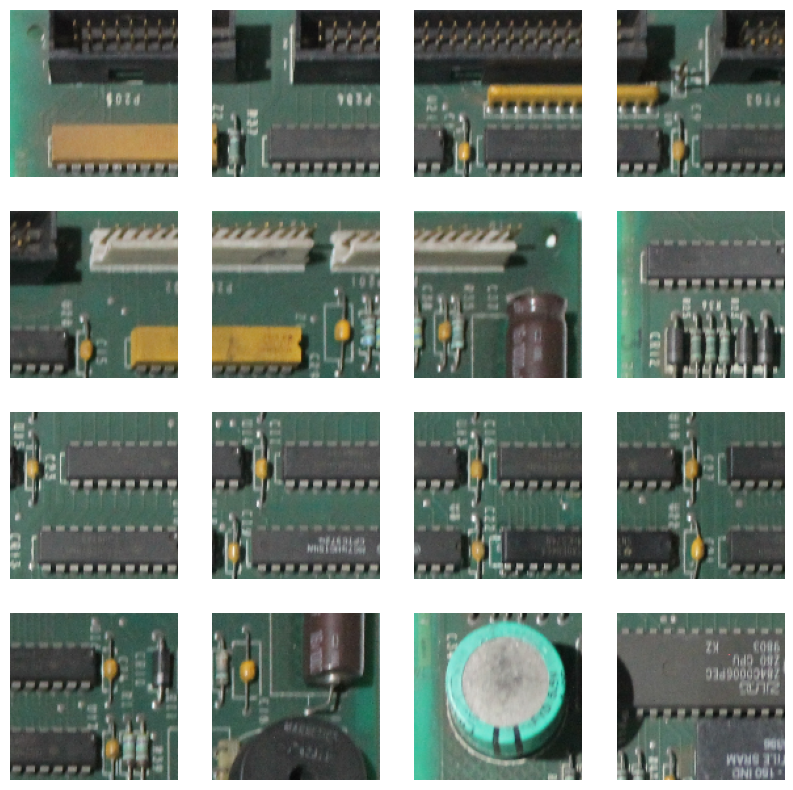

In [ ]:
vision.show_image_samples_from_batch(test_dataset)

In [ ]:
TEST_IMG_IX = 0

generated_test_data = get_generated_image_batch(test_dataset)
show_generated_images(generated_test_data)

(-0.5, 895.5, 639.5, -0.5)

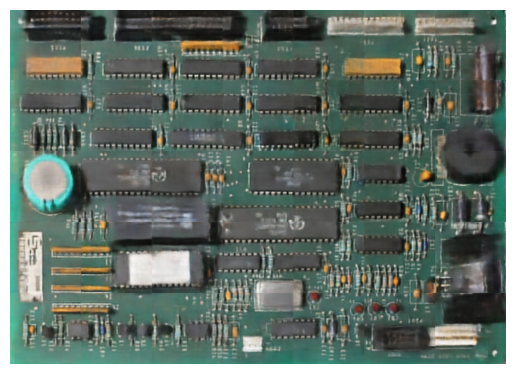

In [ ]:
generated_sample_img = utils.unpatchify_img(generated_test_data[:(grid_width*grid_height)], grid=(grid_width,grid_height))
plt.imshow(generated_sample_img)
plt.axis('off')

Show partitioned image with grids

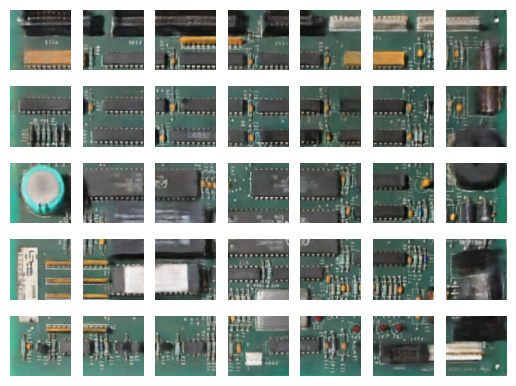

In [ ]:
grid_starter = 0
partitioned_images = []

for ix in range(grid_width*grid_height):
  plt.subplot(grid_height, grid_width, (ix+1))
  plt.imshow(generated_test_data[grid_starter+TEST_IMG_IX])
  # Create partitioned images list to unpatchify
  partitioned_images.append(generated_test_data[grid_starter+TEST_IMG_IX])

  grid_starter += 1
  plt.axis('off')

plt.show()

In [ ]:
def plot_input_and_generated_image_pair(input_batch, generated_batch, plot_ix=0):
    plt.subplot(1,2,1)
    plt.imshow(input_batch[plot_ix])
    plt.title("Real (Input) Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(generated_batch[plot_ix])
    plt.title("Generated Image")
    plt.axis('off')
    plt.show()

In [ ]:
test_batch = next(iter(test_dataset))

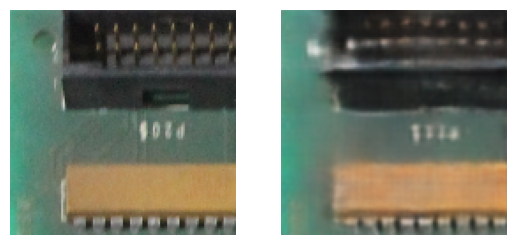

In [ ]:
plot_input_and_generated_image_pair(test_batch, generated_test_data, TEST_IMG_IX)

Difference map shape: (128, 128, 3)
Normalized difference map shape: (128, 128, 3)
Normalized difference map min, avg, max value: (7.277639724634355e-06, 0.07808, 1.0)
Colored difference map shape: (128, 128, 3, 4)


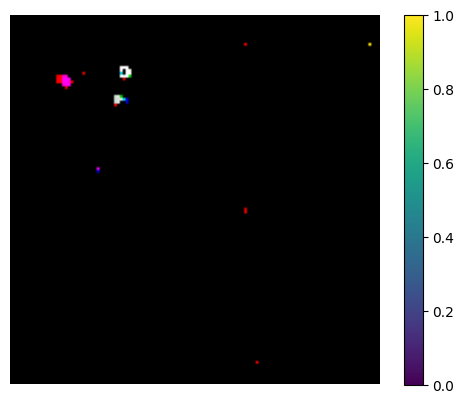

In [ ]:
vision.display_pixel_wise_img_diff(test_batch[TEST_IMG_IX], generated_test_data[TEST_IMG_IX], method="mae", threshold=0.8, channel=0, verbose=1)

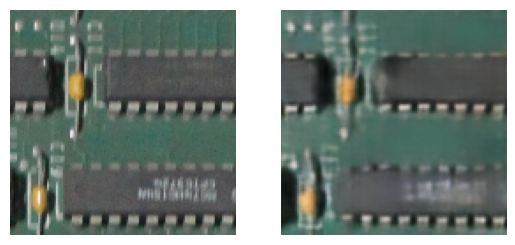

In [ ]:
TEST_IMG_IX = 9

plot_input_and_generated_image_pair(test_batch, generated_test_data, TEST_IMG_IX)

Difference map shape: (128, 128, 3)
Normalized difference map shape: (128, 128, 3)
Normalized difference map min, avg, max value: (1.576451836626802e-06, 0.07416, 1.0)
Colored difference map shape: (128, 128, 3, 4)


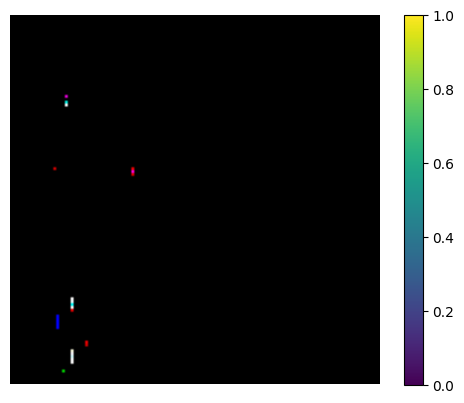

In [ ]:
vision.display_pixel_wise_img_diff(test_batch[TEST_IMG_IX], generated_test_data[TEST_IMG_IX], threshold=0.8, channel=0, verbose=1)

In [ ]:
# Get only defectd image files
X_test = (tf.cast(utils.cvt_color_BGR2RGB(utils.patchify_images(utils.get_image_file_list(MPI_PCB_TEST_DEFECTED_PATH, 'jpg'), patch_size=experiment['PATCH_SIZE'], img_size=modified_image_size)).numpy(), tf.float32) / 255.)

1/1 [==============================] - 0s 73ms/step


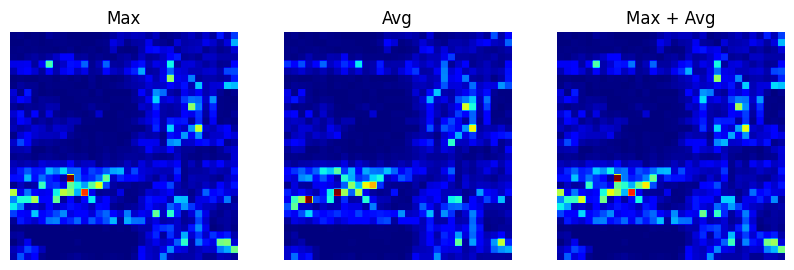

In [ ]:
vision.visualize_feature_heatmap(custom_model, X_test[18], conv_layer_name="conv2d_layer_res_cbam_1", pool="max+avg")

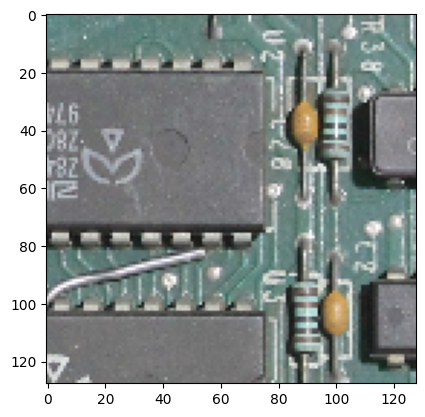

In [ ]:
img_num = 0
ix = 18
ix = (img_num)*(grid_width*grid_height) + ix
plt.imshow(X_test[ix])

1/1 [==============================] - 0s 65ms/step
Difference map shape: (128, 128, 3)
Normalized difference map shape: (128, 128, 3)
Normalized difference map min, avg, max value: (8.166634302142484e-08, 0.09655, 1.0)
Colored difference map shape: (128, 128, 3, 4)


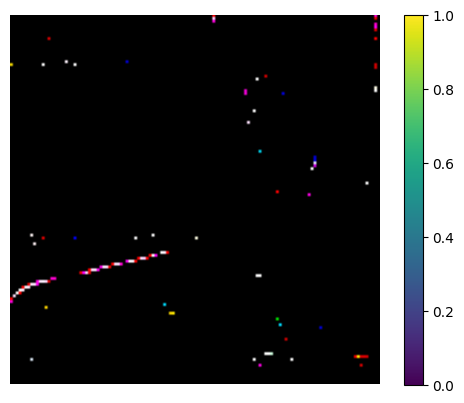

In [ ]:
utils.display_pixel_wise_img_diff(X_test[18], tf.squeeze(custom_model.predict(tf.expand_dims(X_test[18], axis=0))), threshold=0.8, channel=0, verbose=1)

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="conv2d_block_1", pool="max+avg")

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="cbam_2", pool="max")

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="conv2d_transpose_block_6", pool="max")

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="conv2d_transpose_block_5", pool="max")

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="conv2d_transpose_block_4", pool="max")

In [ ]:
vision.visualize_feature_heatmap(custom_model, test_batch[TEST_IMG_IX], conv_layer_name="conv2d_transpose", pool="max")

1/1 [==============================] - 0s 130ms/step


<ipython-input-56-5cca09937509>:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")  # cm.get_cmap will be deprecated after few releases


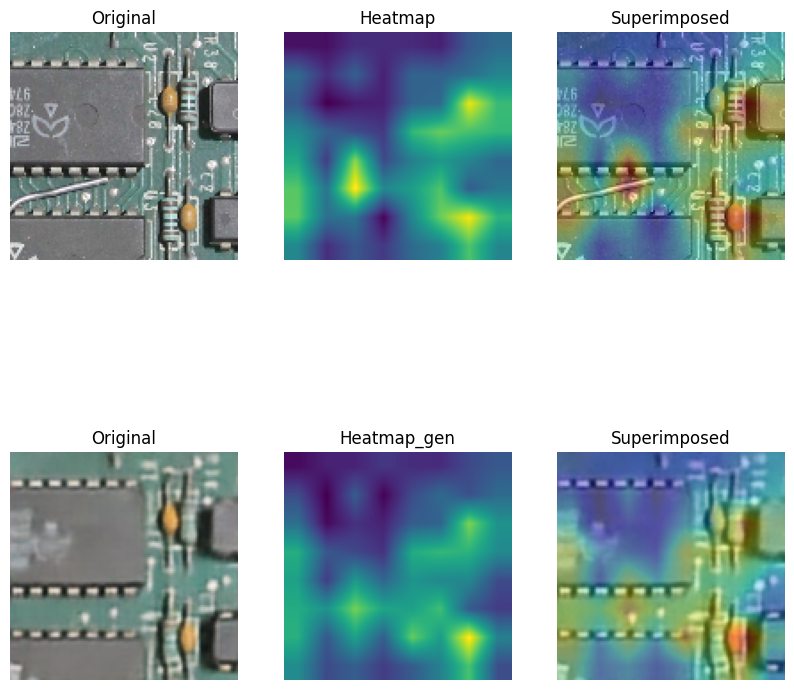

In [ ]:
gradCAM = GradCAM(custom_model, "conv2d_layer_res_cbam_3") # conv2d_layer_res_cbam_1

X_test_gen = tf.squeeze(custom_model.predict(tf.expand_dims(X_test[18], axis=0)))

(heatmap, output) = gradCAM(np.expand_dims(X_test[18], axis=0), X_test[18]*255, alpha=0.4)
(heatmap_gen, output_gen) = gradCAM(np.expand_dims(X_test_gen, axis=0), X_test_gen*255, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(X_test[18])
plt.title("Original")
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(X_test_gen)
plt.title("Original")
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(heatmap_gen)
plt.title("Heatmap_gen")
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(output_gen)
plt.title("Superimposed")
plt.axis('off')
plt.show()